In [1]:
from utils.video_dataset import VideoFrameDataset
from config.torch_config import get_transform, device, normalize
from config.dataset import get_dataset_path


## HYPERPARAMETERS

In [2]:
NUM_SEGMENTS = 10
FRAMES_PER_SEGMENT = 5
BATCH_SIZE = 32
IMAGE_SIZE = 224
IMAGE_RANDOM_CROP_RESIZE = 0.8
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
DEBUG = False


In [3]:
data_path, model_path = get_dataset_path(dataset="WLASL/videos", model_name="WLASL")
multiple_transform = get_transform(IMAGE_SIZE, IMAGE_RANDOM_CROP_RESIZE)


In [4]:
dataset = VideoFrameDataset(
    root_path=data_path,
    transform=multiple_transform,
    num_segments=NUM_SEGMENTS,
    frames_per_segment=FRAMES_PER_SEGMENT,
)

classes = dataset.classes
print(classes)


['before', 'book', 'candy', 'chair', 'clothes']


In [5]:
from utils.loader import split_dataset


In [6]:
train_loader, test_loader, validation_loader = split_dataset(
    dataset, train_split=0.70, validation_split=0.1, batch_size=BATCH_SIZE
)


In [7]:
print(len(train_loader), len(validation_loader), len(test_loader))


6 1 2


### Example of input of net.

> Initial input = [BATCH_SIZE, NUMBER_OF_FRAMES, CHANNELS, HEIGHT, WIDTH]

This example shows first example (first video) in first batch

In [8]:
from utils.output import plot_tensor
from torchvision.utils import make_grid
from torch import nn


In [9]:
def plot_grid(
    tensor, dims=(1, 2, 0), nrow=FRAMES_PER_SEGMENT*NUM_SEGMENTS, norm=True, start_dim=0, end_dim=1
):
    flat = nn.Flatten(start_dim=start_dim, end_dim=end_dim) # Flatten batch to plot.

    flatted_tensor = flat(tensor)
    grid = make_grid(flatted_tensor.cpu(), nrow=nrow)

    if norm:
        grid = normalize(grid)

    plot_tensor(grid, dims)


### Show input of the net (entire batch)

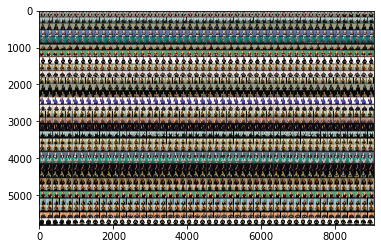

In [10]:
first_batch = next(iter(train_loader))[0]
plot_grid(first_batch)

### The net will then make first and second convolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 16, 2, 90, 90])
torch.Size([32, 32, 1, 45, 45])


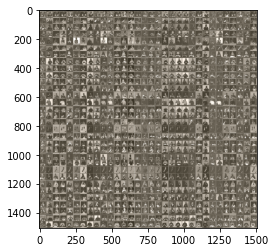

In [11]:
hidden_1, hidden_2 = 16, 32

conv1 = nn.Conv3d(FRAMES_PER_SEGMENT*NUM_SEGMENTS, hidden_1, kernel_size=(2, 3, 3), stride=2, padding=1)
conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, stride=2, padding=1)
relu = nn.LeakyReLU()
batch_1 = nn.BatchNorm3d(hidden_1)
batch_2 = nn.BatchNorm3d(hidden_2)

x = first_batch

x = conv1(x)
x = relu(x)
x = batch_1(x)

print(x.shape)

x = conv2(x)
x = relu(x)
x = batch_2(x)

print(x.shape)


plot_grid(x, nrow=hidden_2)

## Check balance status of the loaders

In [12]:
# from utils.balance import check_balance_status

# print(check_balance_status(test_loader, classes))
# print(check_balance_status(validation_loader, classes))
# print(check_balance_status(train_loader, classes))


In [13]:
# from lib.model import resnet34 as resnet

# model = resnet(sample_duration=FRAMES_PER_SEGMENT*NUM_SEGMENTS, sample_size=IMAGE_SIZE, num_classes=len(classes))
# model


In [14]:
from lib.simple_model import CNN

model = CNN(
    num_classes=len(classes),
    batch_size=BATCH_SIZE,
    num_frames=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    image_size=int(IMAGE_SIZE * IMAGE_RANDOM_CROP_RESIZE),
    debug=DEBUG,
)

print(model)


CNN(
  (conv_relu): LeakyReLU(negative_slope=0.01)
  (lin_relu): LeakyReLU(negative_slope=0.01)
  (conv1): Sequential(
    (0): Conv3d(50, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=7744, out_features=1936, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (batch_out): BatchNorm1d(1936, eps=1e-05, momentum=0.

In [15]:
from lib.train import train_model


In [16]:
train_costs, val_costs, train_accs, val_accs = train_model(
    model,
    train_loader,
    validation_loader,
    device,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
)


Training on device: cuda
Epoch: 1/100 | Train Loss: 1.6873 | Val Loss: 1.7385 | Train Acc: 27.2727% | Val Acc: 14.8148% |  LR: 0.0010
Epoch: 2/100 | Train Loss: 1.5409 | Val Loss: 2.3388 | Train Acc: 31.5508% | Val Acc: 11.1111% |  LR: 0.0010
Epoch: 3/100 | Train Loss: 1.4516 | Val Loss: 1.8197 | Train Acc: 40.6417% | Val Acc: 22.2222% |  LR: 0.0010
Epoch: 4/100 | Train Loss: 1.3466 | Val Loss: 2.1958 | Train Acc: 43.8503% | Val Acc: 7.4074% |  LR: 0.0010
Epoch: 5/100 | Train Loss: 1.2554 | Val Loss: 1.6435 | Train Acc: 43.3155% | Val Acc: 33.3333% |  LR: 0.0010
Epoch: 6/100 | Train Loss: 1.1935 | Val Loss: 1.5259 | Train Acc: 48.6631% | Val Acc: 51.8519% |  LR: 0.0010
Epoch: 7/100 | Train Loss: 1.1006 | Val Loss: 1.0586 | Train Acc: 56.1497% | Val Acc: 51.8519% |  LR: 0.0010
Epoch: 8/100 | Train Loss: 1.0323 | Val Loss: 0.9589 | Train Acc: 60.4278% | Val Acc: 66.6667% |  LR: 0.0010
Epoch: 9/100 | Train Loss: 0.9890 | Val Loss: 0.8531 | Train Acc: 61.4973% | Val Acc: 59.2593% |  LR: 0.

In [17]:
from utils.output import plot_costs

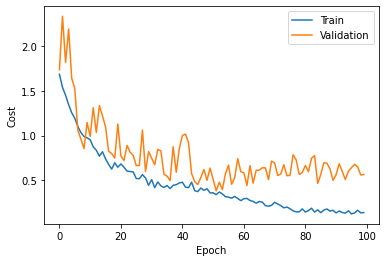

<Figure size 72x72 with 0 Axes>

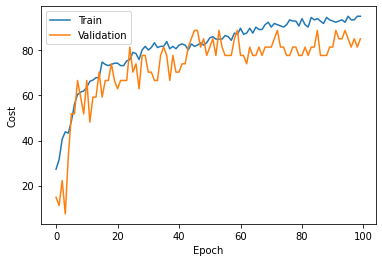

<Figure size 72x72 with 0 Axes>

In [18]:
plot_costs(train_costs, val_costs)
plot_costs(train_accs, val_accs)

In [19]:
from lib.test import check_accuracy


## Probamos el acc con el dataset de prueba reservado

In [20]:
check_accuracy(train_loader, model, classes, device, n_batchs=10)


Predictions for batch 1 
['candy', 'before', 'before', 'clothes', 'book', 'candy', 'candy', 'book', 'book', 'before', 'clothes', 'candy', 'candy', 'chair', 'book', 'chair', 'book', 'book', 'clothes', 'chair', 'candy', 'chair', 'candy', 'chair', 'clothes', 'book', 'before', 'candy', 'book', 'clothes', 'book', 'candy']
Ground truth for batch 1
['candy', 'before', 'before', 'before', 'book', 'candy', 'candy', 'book', 'book', 'before', 'clothes', 'candy', 'candy', 'chair', 'before', 'chair', 'book', 'book', 'clothes', 'chair', 'candy', 'chair', 'candy', 'chair', 'clothes', 'book', 'book', 'candy', 'book', 'clothes', 'book', 'candy']
---------------------------------


Predictions for batch 2 
['chair', 'clothes', 'book', 'chair', 'clothes', 'clothes', 'clothes', 'before', 'clothes', 'before', 'chair', 'chair', 'chair', 'candy', 'clothes', 'book', 'clothes', 'chair', 'before', 'candy', 'book', 'chair', 'book', 'clothes', 'candy', 'candy', 'before', 'before', 'book', 'book', 'chair', 'before

In [21]:
check_accuracy(validation_loader, model, classes, device)

Predictions for batch 1 
['chair', 'candy', 'book', 'candy', 'book', 'clothes', 'before', 'book', 'book', 'book', 'clothes', 'clothes', 'before', 'before', 'book', 'book', 'chair', 'before', 'book', 'chair', 'clothes', 'before', 'book', 'chair', 'book', 'before', 'chair']
Ground truth for batch 1
['chair', 'candy', 'book', 'candy', 'book', 'clothes', 'before', 'book', 'book', 'book', 'chair', 'clothes', 'before', 'book', 'book', 'before', 'book', 'candy', 'book', 'chair', 'clothes', 'before', 'book', 'chair', 'book', 'before', 'chair']
---------------------------------


Got 22 / 27 with accuracy 81.48


In [22]:
check_accuracy(test_loader, model, classes, device)

Predictions for batch 1 
['book', 'book', 'candy', 'book', 'clothes', 'before', 'candy', 'candy', 'clothes', 'chair', 'book', 'candy', 'before', 'before', 'candy', 'chair', 'candy', 'candy', 'candy', 'candy', 'chair', 'candy', 'clothes', 'candy', 'book', 'book', 'candy', 'book', 'book', 'clothes', 'clothes', 'clothes']
Ground truth for batch 1
['book', 'book', 'candy', 'book', 'before', 'before', 'candy', 'candy', 'clothes', 'book', 'book', 'candy', 'before', 'before', 'candy', 'chair', 'before', 'candy', 'candy', 'candy', 'chair', 'candy', 'clothes', 'before', 'book', 'book', 'candy', 'book', 'book', 'clothes', 'clothes', 'clothes']
---------------------------------


Predictions for batch 2 
['before', 'book', 'book', 'before', 'before', 'before', 'before', 'before', 'candy', 'clothes', 'clothes', 'book', 'candy', 'clothes', 'clothes', 'candy', 'clothes', 'book', 'before', 'clothes', 'candy', 'chair']
Ground truth for batch 2
['before', 'book', 'book', 'candy', 'book', 'before', 'bef

## Exportamos modelo

In [23]:
from torch import save

In [24]:
save(model, model_path)
print(f"Model exported to {model_path}")


Model exported to d:\Proyectos\TFG\Sign2Text\Project\models\WLASL.pth


TODO: Add inference by webcam

La solución al dataset de mierda de signos se puede arreglar recortando las manos, una o dos, concatenando y añadiendo la translación del recorte de las manos en el video. (Ej: dos cuadros de las dos manos y el movimieto en x e y que hace el cuadro recortado en el video. De esa forma usamos el gesto de la mano más la translación)

Eso o pasar a pose y centrarse en el movimiento de la pose de los brazos únicamente. O de otros igual también (Pero 100% no piernas etc)

TODO: Add export to onxx para visualizar en la página esa chula